In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

%matplotlib inline

In [2]:
epochs = 5
batch_size = 50

In [3]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [9]:
def generate_model(x_train):
    model = keras.models.Sequential([
      keras.layers.LSTM(198, return_sequences=True,  input_shape=(99, 1)),
      keras.layers.LSTM(99, return_sequences=False),
      keras.layers.RepeatVector(1),
      keras.layers.LSTM(99, return_sequences=True),
      keras.layers.LSTM(198, return_sequences=True),
      keras.layers.TimeDistributed(keras.layers.Dense(1))
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy())

    
    return model

In [14]:
def generate_model(x_train):
    model = keras.models.Sequential([
      keras.layers.Dense(11, activation="relu", input_shape=[99] ),
      keras.layers.Dense(9, activation="relu"),      
      keras.layers.Dense(3, activation="relu"),
      keras.layers.Dense(9, activation="relu"),
      keras.layers.Dense(11, activation="relu"),
      keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy())

    
    return model

In [5]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [15]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]



    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [16]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('iot-util.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].to_numpy()

    # train on first 500 samples and test on last 160 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)

    
    if model is None:
        model = generate_model(X_train)

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test, verbose=1)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (160, 99)
Training...
Epoch 1/5
10/10 [==============================] - 1s 18ms/step - loss: 0.7046 - val_loss: 0.6807
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: 0.6687 - val_loss: 0.6507
Epoch 3/5
10/10 [==============================] - 0s 4ms/step - loss: 0.6272 - val_loss: 0.5988
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 0.5407 - val_loss: 0.4863
Epoch 5/5
10/10 [==============================] - 0s 4ms/step - loss: 0.3833 - val_loss: 0.2503
Predicting...
5/5 [==============================] - 0s 2ms/step
Reshaping predicted


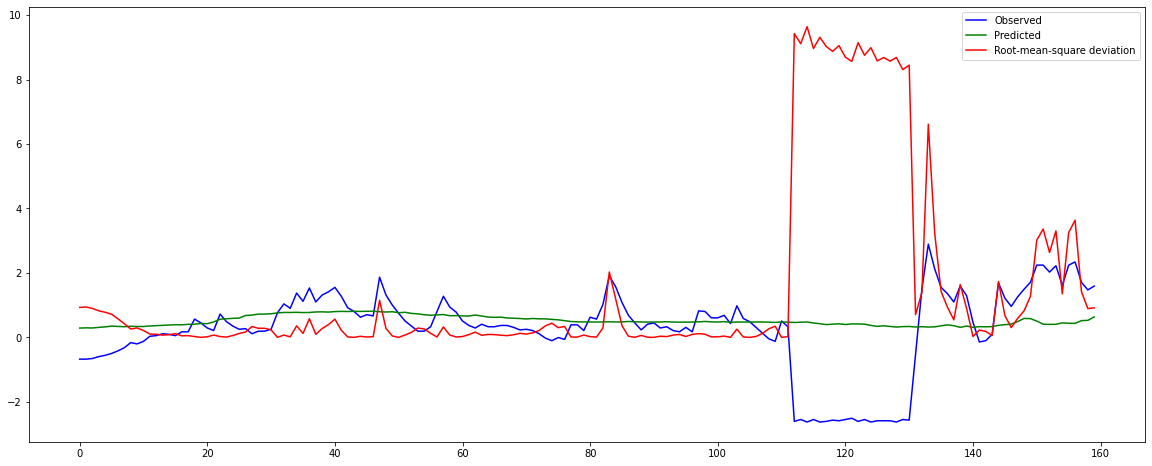

Training duration:1.3069908618927002


In [17]:
model, y_test, predicted = run()

In [13]:
#anomaly threshold of 5 chosen based on empirical analyses
start_time = 0
threshold = 5
for i in range(0, len(predicted)-1):
    if ((y_test[i] - predicted[i]) ** 2) > threshold:
        print("Anomaly at time", start_time+i, "RMSE value:", (y_test[i] - predicted[i]) ** 2)
    i = i+1

Anomaly at time 112 RMSE value: 7.420408810937544
Anomaly at time 113 RMSE value: 7.072177216655039
Anomaly at time 114 RMSE value: 7.4614389347909835
Anomaly at time 115 RMSE value: 7.0007161756827125
Anomaly at time 116 RMSE value: 7.390463587367272
Anomaly at time 117 RMSE value: 7.25526082410177
Anomaly at time 118 RMSE value: 7.023861443346811
Anomaly at time 119 RMSE value: 7.1169109664761825
Anomaly at time 120 RMSE value: 6.905199328055141
Anomaly at time 121 RMSE value: 6.704645190333175
Anomaly at time 122 RMSE value: 7.236772718277932
Anomaly at time 123 RMSE value: 6.938196070117334
Anomaly at time 124 RMSE value: 7.379370968723783
Anomaly at time 125 RMSE value: 7.1871159398438405
Anomaly at time 126 RMSE value: 7.207539215047158
Anomaly at time 127 RMSE value: 7.227086502458784
Anomaly at time 128 RMSE value: 7.459069082197299
Anomaly at time 129 RMSE value: 7.050820114095155
Anomaly at time 130 RMSE value: 7.170612194288072
Anomaly at time 133 RMSE value: 7.7184394768577